In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv')

## объединим наборы 

In [4]:
train.shape, test.shape

((36210, 35), (34686, 32))

In [5]:
train.drop(['index',
            'location'], axis=1, inplace=True)
train['is_train'] = True
test['is_train'] = False
test['price'] = 0

train.index = range(test.shape[0], test.shape[0]+train.shape[0]) # чтобы индексы теста не потерялись, а в трейне продолжилась нумерация

df = test.append(train, verify_integrity=True)

In [6]:
df.shape

(70896, 34)

In [7]:
sum(train.duplicated(['car_url']))

0

In [8]:
sum(test.duplicated(['car_url']))

0

In [9]:
sum(df.duplicated(['car_url']))

10472

In [10]:
sum(df.duplicated(['car_url']))

10472

## Процедура преобразования данных

In [20]:
def add_features_part_one(df):
    df.loc[df.engineDisplacement == ' LTR', 'engineDisplacement'] = None
    df.engineDisplacement = df.engineDisplacement.str.replace('LTR','').astype(float)
    df.enginePower = df.enginePower.str.replace('N12','').astype(float)
    df.loc[df.ПТС.isna(),'ПТС'] = 'Оригинал'
    df.loc[df.Владельцы.isna(),'Владельцы'] = 'Неизвестно'

In [28]:
add_features_part_one(df)

## Отбираем признаки

In [21]:
df.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,is_train,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5.0,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017.0,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5.0,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013.0,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5.0,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,False,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70896 entries, 0 to 70895
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              70896 non-null  object 
 1   brand                 70896 non-null  object 
 2   car_url               70896 non-null  object 
 3   color                 70896 non-null  object 
 4   complectation_dict    42628 non-null  object 
 5   description           69896 non-null  object 
 6   engineDisplacement    70896 non-null  object 
 7   enginePower           70896 non-null  object 
 8   equipment_dict        60900 non-null  object 
 9   fuelType              70896 non-null  object 
 10  image                 70896 non-null  object 
 11  mileage               70896 non-null  int64  
 12  modelDate             70896 non-null  float64
 13  model_info            70896 non-null  object 
 14  model_name            70896 non-null  object 
 15  name               

In [23]:
df.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description              1000
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                6620
Владение                49577
ПТС                       160
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
is_train                    0
price     

### bodyType

In [24]:
df.bodyType.value_counts()

внедорожник 5 дв.          28277
седан                      24621
лифтбек                     4924
хэтчбек 5 дв.               3884
универсал 5 дв.             2490
минивэн                     1754
купе                        1578
компактвэн                   928
хэтчбек 3 дв.                855
пикап двойная кабина         569
внедорожник 3 дв.            248
купе-хардтоп                 217
кабриолет                    170
родстер                      150
фургон                       144
микровэн                      22
седан-хардтоп                 15
седан 2 дв.                   12
пикап одинарная кабина        11
лимузин                        9
пикап полуторная кабина        7
внедорожник открытый           4
тарга                          4
фастбек                        2
универсал 3 дв.1               1
Name: bodyType, dtype: int64

### brand

In [25]:
df.brand.value_counts()

BMW           8203
VOLKSWAGEN    8173
NISSAN        8014
MERCEDES      7918
TOYOTA        7430
AUDI          6878
MITSUBISHI    6232
SKODA         6163
VOLVO         4259
HONDA         3148
LEXUS         2387
INFINITI      2091
Name: brand, dtype: int64

### color

In [26]:
df.color.value_counts()

чёрный         23823
белый          13183
серый          12174
синий           6932
серебристый     4113
красный         3061
зелёный         1833
коричневый      1501
золотистый      1157
голубой          874
бежевый          639
фиолетовый       639
жёлтый           397
оранжевый        294
пурпурный        254
розовый           22
Name: color, dtype: int64

### engineDisplacement

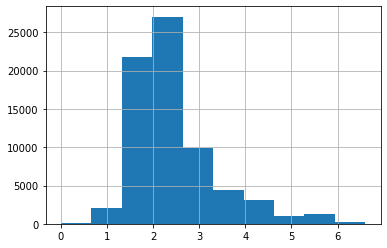

In [29]:
df.engineDisplacement.hist();

### enginePower

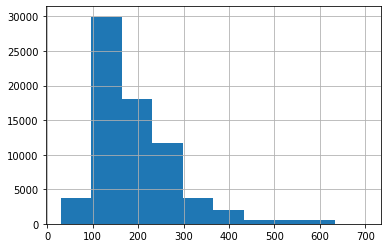

In [30]:
df.enginePower.hist();

### fuelType

In [31]:
df.fuelType.value_counts()

бензин     58030
дизель     12211
гибрид       529
электро      114
газ           12
Name: fuelType, dtype: int64

### mileage

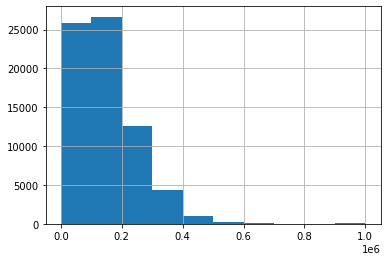

In [32]:
df.mileage.hist();

### modelDate

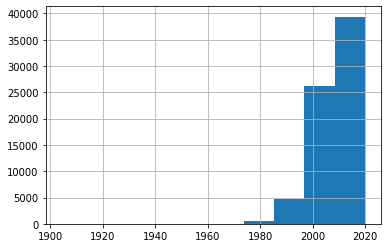

In [33]:
df.modelDate.hist();

### model_name

In [34]:
df.model_name.value_counts()

OCTAVIA            2835
OUTLANDER          1604
LANCER             1544
POLO               1457
A6                 1360
                   ... 
100_SERIES            1
LANCER RALLIART       1
MARK X ZIO            1
VERSO-S               1
E_TRON                1
Name: model_name, Length: 733, dtype: int64

### number of doors

In [35]:
df.numberOfDoors.value_counts()

5.0    41152
4.0    26389
2.0     2167
3.0     1186
0.0        2
Name: numberOfDoors, dtype: int64

In [36]:
df[df.numberOfDoors == 0]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,is_train,price
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000,1904.0,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 л.с.),0.0,1603245843,RUB,1904,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен,False,0
63781,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes-benz/s...,белый,{'id': '0'},"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,{},бензин,//avatars.mds.yandex.net/get-autoru-vos/160126...,48000,1904.0,"{'code': 'SIMPLEX', 'name': 'Simplex', 'ru_nam...",SIMPLEX,5.3 MT (32 л.с.),0.0,1574259251000,RUR,1904,1093802104-d76601f9,"{'id': '21743718', 'year_from': 1904, 'year_to...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,"{'year': 2014, 'month': 2}",Оригинал,задний,Правый,Не требует ремонта,Растаможен,True,12000000


### transmission

In [37]:
df.vehicleTransmission.value_counts()

автоматическая      39222
механическая        14094
вариатор             8832
роботизированная     8748
Name: vehicleTransmission, dtype: int64

### vendor

In [38]:
df.vendor.value_counts()

EUROPEAN    41594
JAPANESE    29302
Name: vendor, dtype: int64

### Руль

In [39]:
df['Руль'].value_counts()

Левый     68327
Правый     2569
Name: Руль, dtype: int64

### Привод

In [40]:
df['Привод'].value_counts()

полный      33294
передний    30737
задний       6865
Name: Привод, dtype: int64

### Владельцы

In [41]:
df['Владельцы'].value_counts()

3 или более    29078
1 владелец     18197
2 владельца    17001
Неизвестно      6620
Name: Владельцы, dtype: int64

### ПТС

In [42]:
df['ПТС'].value_counts()

Оригинал    62254
Дубликат     8642
Name: ПТС, dtype: int64

## Сохраняем данные после обработки

In [44]:
df.to_csv('data1.csv', index=False)

## Отбираем признаки для модели

Первая модель будет очень простая, поэтому выберем прмзнаки, которые не требуют предобработки

In [78]:
cat_cols = ['bodyType', 'brand', 'fuelType', 'color', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Владельцы', 'Привод', 'Руль']
num_cols = ['productionDate', 'numberOfDoors', 'engineDisplacement', 'enginePower', 'mileage', ]

## Обучаем модель

In [79]:
X = df[df.is_train].drop('price', axis=1).loc[:, cat_cols+num_cols]
y = df[df.is_train].price

In [80]:
X.isna().sum()

bodyType               0
brand                  0
fuelType               0
color                  0
model_name             0
vehicleTransmission    0
vendor                 0
ПТС                    0
Владельцы              0
Привод                 0
Руль                   0
productionDate         0
numberOfDoors          0
engineDisplacement     0
enginePower            0
mileage                0
dtype: int64

In [81]:
model = CatBoostRegressor(cat_features=cat_cols)
model.fit(X, y)

Learning rate set to 0.073939
0:	learn: 2218555.7490826	total: 239ms	remaining: 3m 59s
1:	learn: 2103308.4957258	total: 289ms	remaining: 2m 24s
2:	learn: 1996756.6744303	total: 351ms	remaining: 1m 56s
3:	learn: 1897559.8410884	total: 414ms	remaining: 1m 43s
4:	learn: 1805530.5207517	total: 490ms	remaining: 1m 37s
5:	learn: 1721635.1888356	total: 549ms	remaining: 1m 30s
6:	learn: 1644991.9871962	total: 604ms	remaining: 1m 25s
7:	learn: 1573994.3503350	total: 655ms	remaining: 1m 21s
8:	learn: 1508068.6362676	total: 741ms	remaining: 1m 21s
9:	learn: 1445350.6665958	total: 808ms	remaining: 1m 19s
10:	learn: 1389612.1006850	total: 865ms	remaining: 1m 17s
11:	learn: 1332476.6156228	total: 931ms	remaining: 1m 16s
12:	learn: 1280350.6785417	total: 996ms	remaining: 1m 15s
13:	learn: 1234431.2309873	total: 1.06s	remaining: 1m 14s
14:	learn: 1190563.7167437	total: 1.12s	remaining: 1m 13s
15:	learn: 1151921.4822695	total: 1.19s	remaining: 1m 13s
16:	learn: 1116973.3105222	total: 1.25s	remaining: 1

147:	learn: 554415.2347683	total: 9.09s	remaining: 52.3s
148:	learn: 552683.4043186	total: 9.15s	remaining: 52.3s
149:	learn: 552403.3592952	total: 9.22s	remaining: 52.2s
150:	learn: 552153.8888106	total: 9.26s	remaining: 52.1s
151:	learn: 549871.2804139	total: 9.33s	remaining: 52.1s
152:	learn: 549853.0136612	total: 9.36s	remaining: 51.8s
153:	learn: 549173.3800843	total: 9.41s	remaining: 51.7s
154:	learn: 548585.0877672	total: 9.5s	remaining: 51.8s
155:	learn: 546378.2498270	total: 9.57s	remaining: 51.8s
156:	learn: 545810.4541297	total: 9.64s	remaining: 51.7s
157:	learn: 545566.6932641	total: 9.69s	remaining: 51.6s
158:	learn: 545354.5345173	total: 9.76s	remaining: 51.6s
159:	learn: 545342.4352261	total: 9.78s	remaining: 51.3s
160:	learn: 544825.9164472	total: 9.85s	remaining: 51.3s
161:	learn: 542921.6627461	total: 9.91s	remaining: 51.3s
162:	learn: 541693.9479337	total: 10s	remaining: 51.4s
163:	learn: 541166.0951173	total: 10.1s	remaining: 51.4s
164:	learn: 540984.2875152	total: 

292:	learn: 438440.1081290	total: 18.6s	remaining: 44.9s
293:	learn: 437663.2450081	total: 18.7s	remaining: 44.8s
294:	learn: 437035.1918619	total: 18.7s	remaining: 44.7s
295:	learn: 436618.8589808	total: 18.8s	remaining: 44.6s
296:	learn: 436561.8200303	total: 18.8s	remaining: 44.6s
297:	learn: 436507.3388372	total: 18.9s	remaining: 44.5s
298:	learn: 435817.6851489	total: 19s	remaining: 44.5s
299:	learn: 435765.3186650	total: 19s	remaining: 44.3s
300:	learn: 434704.1130104	total: 19.1s	remaining: 44.3s
301:	learn: 434562.9068026	total: 19.1s	remaining: 44.2s
302:	learn: 434512.8123189	total: 19.2s	remaining: 44.1s
303:	learn: 434388.1994778	total: 19.2s	remaining: 44s
304:	learn: 434340.3935679	total: 19.3s	remaining: 43.9s
305:	learn: 433790.8700433	total: 19.3s	remaining: 43.8s
306:	learn: 433241.3825201	total: 19.4s	remaining: 43.8s
307:	learn: 433123.7630233	total: 19.4s	remaining: 43.6s
308:	learn: 432480.1381663	total: 19.5s	remaining: 43.6s
309:	learn: 432244.6387903	total: 19.

438:	learn: 387698.6656438	total: 27.1s	remaining: 34.6s
439:	learn: 387431.4939605	total: 27.1s	remaining: 34.5s
440:	learn: 387235.6442831	total: 27.2s	remaining: 34.4s
441:	learn: 386875.6141190	total: 27.2s	remaining: 34.4s
442:	learn: 386796.4128323	total: 27.3s	remaining: 34.3s
443:	learn: 386699.9070821	total: 27.4s	remaining: 34.3s
444:	learn: 386420.9403037	total: 27.4s	remaining: 34.2s
445:	learn: 386344.1773662	total: 27.5s	remaining: 34.2s
446:	learn: 386291.2856063	total: 27.6s	remaining: 34.1s
447:	learn: 385934.1742712	total: 27.6s	remaining: 34s
448:	learn: 385866.8686238	total: 27.7s	remaining: 34s
449:	learn: 385552.9726173	total: 27.7s	remaining: 33.9s
450:	learn: 385249.9818389	total: 27.8s	remaining: 33.8s
451:	learn: 385013.9273517	total: 27.9s	remaining: 33.8s
452:	learn: 384744.3923241	total: 27.9s	remaining: 33.7s
453:	learn: 384558.2896836	total: 28s	remaining: 33.6s
454:	learn: 384403.9490462	total: 28s	remaining: 33.6s
455:	learn: 384362.4643794	total: 28.1s

583:	learn: 355252.5744773	total: 36s	remaining: 25.6s
584:	learn: 355192.4286182	total: 36s	remaining: 25.6s
585:	learn: 355170.0125077	total: 36.1s	remaining: 25.5s
586:	learn: 355010.0374331	total: 36.2s	remaining: 25.4s
587:	learn: 354772.7436313	total: 36.2s	remaining: 25.4s
588:	learn: 354697.5797087	total: 36.3s	remaining: 25.3s
589:	learn: 354509.4991446	total: 36.4s	remaining: 25.3s
590:	learn: 354492.0647379	total: 36.4s	remaining: 25.2s
591:	learn: 354391.4150687	total: 36.5s	remaining: 25.1s
592:	learn: 354293.9319252	total: 36.6s	remaining: 25.1s
593:	learn: 354268.5252469	total: 36.7s	remaining: 25.1s
594:	learn: 353988.5954910	total: 36.8s	remaining: 25s
595:	learn: 353965.6981108	total: 36.8s	remaining: 25s
596:	learn: 353854.2068668	total: 36.9s	remaining: 24.9s
597:	learn: 353752.1354371	total: 36.9s	remaining: 24.8s
598:	learn: 353741.7922248	total: 37s	remaining: 24.8s
599:	learn: 353588.3394227	total: 37.1s	remaining: 24.7s
600:	learn: 353319.3525837	total: 37.1s	r

730:	learn: 335714.7129241	total: 45.1s	remaining: 16.6s
731:	learn: 335639.4627370	total: 45.2s	remaining: 16.5s
732:	learn: 335158.5146247	total: 45.3s	remaining: 16.5s
733:	learn: 335088.7936167	total: 45.3s	remaining: 16.4s
734:	learn: 334927.0466109	total: 45.4s	remaining: 16.4s
735:	learn: 334891.5063528	total: 45.5s	remaining: 16.3s
736:	learn: 334730.9668690	total: 45.5s	remaining: 16.3s
737:	learn: 334612.7861193	total: 45.6s	remaining: 16.2s
738:	learn: 334491.1567465	total: 45.7s	remaining: 16.1s
739:	learn: 334409.0944356	total: 45.8s	remaining: 16.1s
740:	learn: 334304.7262839	total: 45.8s	remaining: 16s
741:	learn: 334148.1690255	total: 45.9s	remaining: 16s
742:	learn: 333885.2867160	total: 46s	remaining: 15.9s
743:	learn: 333833.7988905	total: 46s	remaining: 15.8s
744:	learn: 333743.6453526	total: 46.1s	remaining: 15.8s
745:	learn: 333715.5202627	total: 46.2s	remaining: 15.7s
746:	learn: 333600.6931448	total: 46.2s	remaining: 15.7s
747:	learn: 333520.1404006	total: 46.3s

878:	learn: 322882.8049134	total: 54.6s	remaining: 7.52s
879:	learn: 322836.1905379	total: 54.7s	remaining: 7.46s
880:	learn: 322773.1514278	total: 54.8s	remaining: 7.39s
881:	learn: 322655.6566322	total: 54.8s	remaining: 7.33s
882:	learn: 322629.8834916	total: 54.9s	remaining: 7.27s
883:	learn: 322476.8738527	total: 54.9s	remaining: 7.21s
884:	learn: 322446.4527938	total: 55s	remaining: 7.14s
885:	learn: 322403.6563990	total: 55s	remaining: 7.08s
886:	learn: 322345.5150023	total: 55.1s	remaining: 7.02s
887:	learn: 322340.3719438	total: 55.2s	remaining: 6.96s
888:	learn: 322132.1407829	total: 55.3s	remaining: 6.9s
889:	learn: 321964.8412277	total: 55.3s	remaining: 6.84s
890:	learn: 321929.8329435	total: 55.4s	remaining: 6.78s
891:	learn: 321849.6578150	total: 55.4s	remaining: 6.71s
892:	learn: 321810.2832239	total: 55.5s	remaining: 6.65s
893:	learn: 321782.8378668	total: 55.6s	remaining: 6.59s
894:	learn: 321745.0647573	total: 55.6s	remaining: 6.53s
895:	learn: 321449.6416357	total: 55

In [83]:
model.get_best_score()

{'learn': {'RMSE': 314071.1410558236}}

ну так себе разброс  в 314000

In [90]:
pd.Series(model.get_feature_importance(), index=model.feature_names_).sort_values(ascending=False)

enginePower            26.240065
productionDate         18.728183
mileage                15.300073
engineDisplacement     13.365421
brand                  10.172462
Привод                  5.018099
model_name              2.939721
fuelType                2.423767
bodyType                1.902101
Владельцы               1.823259
vehicleTransmission     1.173234
color                   0.609905
vendor                  0.138881
numberOfDoors           0.117047
ПТС                     0.042506
Руль                    0.005277
dtype: float64

In [91]:
X_test = df[~df.is_train].drop('price', axis=1).loc[:, cat_cols+num_cols]

In [93]:
def make_submit(model, X_test, submit_file, index=None):
    pred = np.round(model.predict(X_test))
    answer = pd.Series(pred, index=index, name='price')
    answer.to_csv(submit_file, index_label='sell_id')
    
    

In [94]:
make_submit(model, X_test, submit_file='predict.csv', index=df[~df.is_train].sell_id)

Ну так себе, 22% ошибки и 7 с конца место